## Description of the project:

   In this part of the class, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 


1. The average **daily wind pattern** for the city of Zurich 

2. The **altitude** at which the CO2 sensor is located

3. A clustering of the city of Zurich in 17 different zones and the **city zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define a machine learning algorithm that curates the data, by detecting potential outliers or drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the wind, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.



## Goal:
    
  We would like to use the above knowledge in order to fit a robust regression model to the CO2 measurements. This model should be built by processing the measurements of the entire sensor network jointly, and it should take into account the dependence on the above mentioned parameters. Finally, the learned model will be used to curate the CO2 measurements by detecting possible outliers and drifts. 

**Note:**
Different machine learning approaches can be used to solve the problem. For simplicity, we provide a suggested approach, and the corresponding steps that can guide your solution. 


### Imports

Import the following python packages: pandas, datetime, matplotlib, numpy, sklearn

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition, linear_model
import array
from tqdm import tqdm_notebook as tqdm

### To start with: 

The following csv files will be needed: 

- `CO2_sensor_measurements.csv`

Description: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
- `temperature_humidity.csv`

Description: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
- `sensor_metadata.csv`

Description: It contains the name of the site (LocationName), the zone index (zone), and the altitude in meters. 
    
- `zurich_average_wind.csv`

Description: It contains the average wind speed (wind_speed) in the city of Zurich measured every 30 minutes (timestamp).

In [2]:
CO2_measurement = pd.read_csv('CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('sensors_metadata.csv', sep='\t') 

In [11]:
CO2_measurement.describe

<bound method NDFrame.describe of                   timestamp LocationName  SensorUnit_ID         CO2
0       2017-10-01 00:05:00         ZGHD           1014  593.321562
1       2017-10-01 00:15:00         ZGHD           1014  595.846258
2       2017-10-01 00:25:00         ZGHD           1014  595.845353
3       2017-10-01 00:45:00         ZGHD           1014  599.039129
4       2017-10-01 00:55:00         ZGHD           1014  594.996629
5       2017-10-01 01:05:00         ZGHD           1014  592.838683
6       2017-10-01 01:25:00         ZGHD           1014  600.135336
7       2017-10-01 01:35:00         ZGHD           1014  598.807650
8       2017-10-01 01:45:00         ZGHD           1014  599.730352
9       2017-10-01 01:55:00         ZGHD           1014  597.824917
10      2017-10-01 02:15:00         ZGHD           1014  598.049704
11      2017-10-01 02:25:00         ZGHD           1014  592.683084
12      2017-10-01 02:35:00         ZGHD           1014  595.345017
13      2017-1


## PART I: Handling time series with pandas (15 points)

### Question I.a. (12/15)

Organize the CO2_sensor_measurements.csv and temperature_humidity.csv files into a single dataframe that contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, and the humidity. For each measurement (CO2, humidity, temperature), take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

Hints: the following methods could be useful:

- [pandas.DataFrame.resample()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html)
    
- [pandas.DataFrame.interpolate()](https://pandas.pydata.org/pandasdocs/stable/generated/pandas.DataFrame.interpolate.html)

- [pandas.DataFrame.mean()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html)

- [pandas.DataFrame.append()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html)

In [5]:
CO2_measurement.head(100)

,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562
1,2017-10-01 00:15:00,ZGHD,1014,595.846258
2,2017-10-01 00:25:00,ZGHD,1014,595.845353
3,2017-10-01 00:45:00,ZGHD,1014,599.039129
4,2017-10-01 00:55:00,ZGHD,1014,594.996629
5,2017-10-01 01:05:00,ZGHD,1014,592.838683
6,2017-10-01 01:25:00,ZGHD,1014,600.135336
7,2017-10-01 01:35:00,ZGHD,1014,598.807650
8,2017-10-01 01:45:00,ZGHD,1014,599.730352
9,2017-10-01 01:55:00,ZGHD,1014,597.824917


In [4]:
CO2 = CO2_measurement.interpolate().set_index('timestamp')

In [5]:
CO2.index = pd.to_datetime(CO2.index)
grouper = CO2.groupby([pd.Grouper(freq='30Min'), 'LocationName', 'SensorUnit_ID'])
grouper = grouper.mean()
grouper.head()

CO2
timestamp  LocationName SensorUnit_ID            
2017-10-01 AJGR         1122           340.231893
           BSCR         1120           431.558599
           BUDF         1124           408.391943
           KBRL         1176           402.759373
           KTGM         1211           432.410637

In [6]:
ZU_th = zurich_temp_humidity.interpolate().set_index('Timestamp')
ZU_th.index.names = ['timestamp']

In [7]:
ZU_th.index = pd.to_datetime(ZU_th.index)
ZU_th = ZU_th.resample('30Min').mean()
ZU_th.head(2)

,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,1018.humidity,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,11.396667,92.440806,10.513333,92.204295,11.040000,92.959605,11.04,89.914205,11.370000,91.059886,...,10.130000,97.310903,10.460000,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.886230
2017-10-01 00:30:00,11.303333,91.625097,10.576667,92.773956,10.996667,92.644257,10.96,89.787048,11.273333,89.996857,...,10.116667,97.788694,10.456667,96.094014,10.463333,95.242065,11.290000,90.549988,11.326667,88.851176


In [8]:
grouper = grouper.reset_index()
Ia = pd.DataFrame()

for e in tqdm(ZU_th.columns[::2]):
    id_ = int(e.split('.')[0])
    df = ZU_th[['{}.temperature'.format(id_), '{}.humidity'.format(id_)]].rename(
        columns={
            '{}.temperature'.format(id_): 'temperature',
            '{}.humidity'.format(id_):'humidity'
        }
    )
    df['SensorUnit_ID'] = id_
    Ia = Ia.append(grouper.merge(df.reset_index(), on=['timestamp', 'SensorUnit_ID'])) 
Ia = Ia.set_index('timestamp')

In [9]:
Ia.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


Hint: Your dataframe should look like that

In [10]:
pd.read_csv('Hint_Ia.csv', index_col='Unnamed: 0')

,CO2,LocationName,SensorUnit_ID,temperature,humidity
2017-10-01 00:00:00,595.004391,ZGHD,1014,11.396667,92.440806
2017-10-01 00:30:00,597.017879,ZGHD,1014,11.325000,91.770691
2017-10-01 01:00:00,596.487010,ZGHD,1014,11.240000,91.096761
2017-10-01 01:30:00,598.787639,ZGHD,1014,11.260000,91.275734
2017-10-01 02:00:00,595.366394,ZGHD,1014,11.290000,91.061157


### Question I.b. (3/15)

Export the curated and ready to use timeseries to a csv file. 

In [11]:
Ia.to_csv('Ia.csv')

In [12]:
pd.read_csv('Ia.csv', index_col='timestamp').head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


## PART II: Finding meaningful structures/patterns in the data (20 points)

### Question II.a. (3/20)

Plot the daily median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName).

In [13]:
CO2 = pd.read_csv('Ia.csv', index_col='timestamp')[['LocationName', 'CO2']]
CO2.index = pd.to_datetime(CO2.index)
CO2.head()

,LocationName,CO2
timestamp,,
2017-10-01 00:00:00,ZGHD,595.004391
2017-10-01 00:30:00,ZGHD,597.017879
2017-10-01 01:00:00,ZGHD,596.487010
2017-10-01 01:30:00,ZGHD,598.787639
2017-10-01 02:00:00,ZGHD,595.366394


In [14]:
grouper = CO2.groupby([pd.Grouper(freq='1D'), 'LocationName']).median()
grouper = grouper.unstack()
grouper.head()

CO2                                                  \
LocationName        AJGR        BSCR        BUDF        KBRL        KTGM   
timestamp                                                                  
2017-10-01    337.607582  440.343231  411.103595  403.030303  432.013880   
2017-10-02    340.095487  448.852032  407.405773  391.784944  436.907137   
2017-10-03    336.386608  436.999941  405.024573  393.706657  433.309679   
2017-10-04    334.596193  478.421906  440.445634  413.908086  447.879215   
2017-10-05    329.236632  450.064610  401.552411  391.629731  427.806292   

                                                                          \
LocationName        RCTZ        SMHK        SZGL        ULGW        UTLI   
timestamp                                                                  
2017-10-01    449.490896  490.112429  472.681707  428.562032  773.440351   
2017-10-02    432.869007  482.156286  466.532918  419.905347  772.618116   
2017-10-03    430.224079  484.132565  464.822418  417.493715  764.027294   
2017-10-04    463.487078  504.331058  505.039307  421.821252  772.952145   
2017-10-05    427.155296  486.412493  462.212215  416.115287  783.483923   

                 ...                                                      \
LocationName     ...            ZSBN        ZSCH        ZSEF        ZSTA   
timestamp        ...                                                       
2017-10-01       ...      424.404593  429.799244  437.054210  417.224659   
2017-10-02       ...      417.837019  427.573693  428.912049  414.923289   
2017-10-03       ...      417.321688  427.421512  430.412299  413.855254   
2017-10-04       ...      432.198341  455.585540  459.105776  436.745539   
2017-10-05       ...      409.083908  422.707916  423.522065  413.552230   

                                                                          \
LocationName        ZSTL        ZSZW        ZTBN        ZUBG         ZUE   
timestamp                                                                  
2017-10-01    486.823849  464.470649  443.260325  409.324396  424.436515   
2017-10-02    467.970726  449.616066  439.991300  403.906469  416.390855   
2017-10-03    468.939903  450.182120  434.690250  402.013783  416.167200   
2017-10-04    515.057413  472.724286  450.598995  413.561709  432.288361   
2017-10-05    465.165948  447.007174  432.424298  397.721634  414.735165   

                          
LocationName        ZWCH  
timestamp                 
2017-10-01    436.902637  
2017-10-02    423.229120  
2017-10-03    426.203329  
2017-10-04    450.966401  
2017-10-05    421.565781  

[5 rows x 46 columns]

In [15]:
grouper = grouper.resample('1M').median()
grouper.head()

CO2                                                  \
LocationName       AJGR        BSCR        BUDF        KBRL        KTGM   
timestamp                                                                 
2017-10-31    334.04137  482.733537  428.981932  406.778297  444.205931   

                                                                          \
LocationName        RCTZ        SMHK        SZGL        ULGW        UTLI   
timestamp                                                                  
2017-10-31    456.369576  520.359674  503.173041  430.091136  775.490215   

                 ...                                                      \
LocationName     ...            ZSBN        ZSCH        ZSEF        ZSTA   
timestamp        ...                                                       
2017-10-31       ...      419.952782  446.066282  449.150163  431.835541   

                                                                         \
LocationName        ZSTL       ZSZW        ZTBN        ZUBG         ZUE   
timestamp                                                                 
2017-10-31    505.483841  462.91584  463.196089  413.416412  433.140153   

                          
LocationName        ZWCH  
timestamp                 
2017-10-31    450.443069  

[1 rows x 46 columns]

In [16]:
grouper = grouper.reset_index()
grouper = grouper.drop('timestamp', 1)
grouper.head()

/Users/Joel/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  


CO2                                                  \
LocationName       AJGR        BSCR        BUDF        KBRL        KTGM   
0             334.04137  482.733537  428.981932  406.778297  444.205931   

                                                                          \
LocationName        RCTZ        SMHK        SZGL        ULGW        UTLI   
0             456.369576  520.359674  503.173041  430.091136  775.490215   

                 ...                                                      \
LocationName     ...            ZSBN        ZSCH        ZSEF        ZSTA   
0                ...      419.952782  446.066282  449.150163  431.835541   

                                                                         \
LocationName        ZSTL       ZSZW        ZTBN        ZUBG         ZUE   
0             505.483841  462.91584  463.196089  413.416412  433.140153   

                          
LocationName        ZWCH  
0             450.443069  

[1 rows x 46 columns]

In [17]:
daily_median_CO2 = grouper['CO2']
daily_median_CO2 = daily_median_CO2.T
daily_median_CO2.columns = ['CO2']
daily_median_CO2.head()

,CO2
LocationName,
AJGR,334.041370
BSCR,482.733537
BUDF,428.981932
KBRL,406.778297
KTGM,444.205931


In [18]:
SM = sensors_metadata[['LocationName', 'altitude']].set_index('LocationName')
SM.head()

,altitude
LocationName,
AJGR,627.8
BSCR,462.3
BUDF,490.2
KBRL,510.5
KTGM,530.3


In [19]:
merged_df = SM.join(daily_median_CO2)
merged_df.head()

,altitude,CO2
LocationName,,
AJGR,627.8,334.041370
BSCR,462.3,482.733537
BUDF,490.2,428.981932
KBRL,510.5,406.778297
KTGM,530.3,444.205931


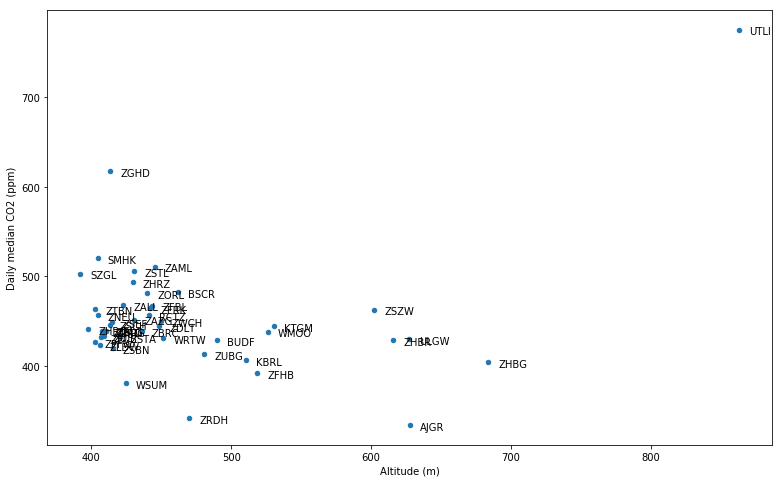

In [20]:
ax = merged_df.plot(x='altitude', y='CO2', kind='scatter', figsize=(13,8))

for k, v in merged_df.iterrows():
    ax.annotate(k, v, xytext=(10,-5), textcoords='offset points', fontsize=10)

plt.ylabel('Daily median CO2 (ppm)')
plt.xlabel('Altitude (m)')
plt.show()

### Question II.b. (7/20)

**Altitude clustering:** Cluster the sites based on their altitude, by performing a K-means clustering. Set the number of clusters to 4. 

In [21]:
mat = SM.as_matrix()
km = cluster.KMeans(n_clusters=4)
km.fit(mat)
labels = km.labels_
SM['cluster'] = labels
SM.head()

,altitude,cluster
LocationName,,
AJGR,627.8,1
BSCR,462.3,0
BUDF,490.2,0
KBRL,510.5,0
KTGM,530.3,0


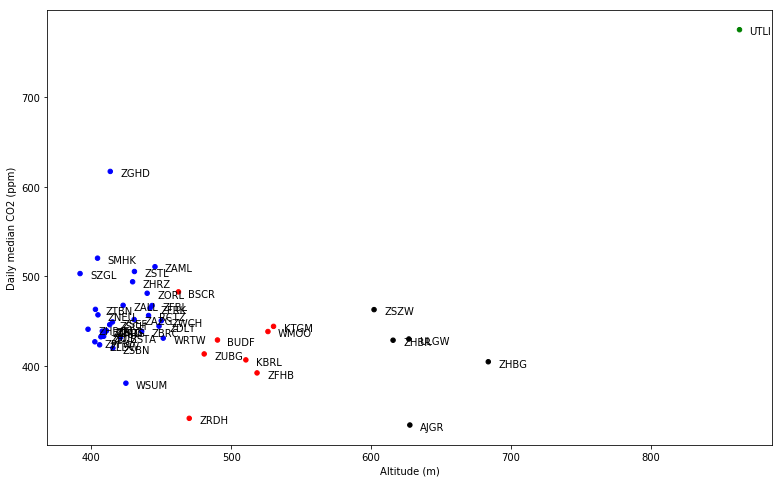

In [22]:
LABEL_COLOR_MAP = { 0 : 'r', 1 : 'k', 2 : 'g', 3 : 'b' }
label_color = [LABEL_COLOR_MAP[l] for l in labels]

ax = merged_df.plot(x='altitude', y='CO2', kind='scatter', c=label_color, figsize=(13,8))

for k, v in merged_df.iterrows():
    ax.annotate(k, v, xytext=(10,-5), textcoords='offset points', fontsize=10)
    

plt.ylabel('Daily median CO2 (ppm)')
plt.xlabel('Altitude (m)')
plt.show()

### Question II.c. (7/20)

**Temporal clustering:** Cluster the days of the month based on the average wind conditions of the city of Zurich. 

First, resample the daily wind signal by computing the mean over an interval of 30 min. 

Then, consider each day as a 48-dimensional sample (30 min intervals per day). Perform a principle component analysis of the wind values to reduce the dimension to 2.  
Hint: You can use `pandas.DataFrame.grouby()` and `for` to generate the daily sample ([documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html#iterating-through-groups)).

Finally, apply K-means to the first two PCA coefficients. Set the number of clusters to 6.

In [23]:
ZU_aw = zurich_average_wind.copy()
ZU_aw.set_index('timestamp', inplace=True)
ZU_aw.index = pd.to_datetime(ZU_aw.index)
ZU_aw.head()

,wind_speed
timestamp,
2017-10-01 00:00:00,2.330000
2017-10-01 00:30:00,1.480000
2017-10-01 01:00:00,0.950000
2017-10-01 01:30:00,0.923333
2017-10-01 02:00:00,0.776667


In [24]:
# the dataframe is already meaned over an interval of 30 min
ZU_aw.equals(ZU_aw.resample('30min').mean())

True

In [25]:
pca = decomposition.PCA(n_components=2)
daily_sample = pd.DataFrame(columns=list(range(48)))

for index, row in ZU_aw.groupby(ZU_aw.index.day):
    day = row.index[0].date()
    daily_sample.loc[day] = row.as_matrix().T[0]

pca_components = pd.DataFrame(columns=['component_1', 'component_2'], index=daily_sample.index)
components_values = pca.fit_transform(daily_sample.as_matrix())
pca_components.loc[:] = components_values
pca_components.index.names = ['timestamp']
pca_components.head()

,component_1,component_2
timestamp,,
2017-10-01,-4.106523,-1.663550
2017-10-02,-0.869377,4.207631
2017-10-03,8.023951,-8.309913
2017-10-04,-3.281485,-0.074907
2017-10-05,8.288445,11.560985


In [26]:
mat = pca_components.as_matrix()
km = cluster.KMeans(n_clusters=6)
km.fit(mat)
labels = km.labels_
pca_components['cluster'] = labels
pca_components.head()

,component_1,component_2,cluster
timestamp,,,
2017-10-01,-4.106523,-1.663550,4
2017-10-02,-0.869377,4.207631,0
2017-10-03,8.023951,-8.309913,3
2017-10-04,-3.281485,-0.074907,0
2017-10-05,8.288445,11.560985,2


### Question II.d. (3/20)

Choose one of the wind clusters, and plot the average wind of the days corresponding to that cluster. 

In [27]:
cluster = 1
days_of_interest = pca_components[pca_components['cluster'] == cluster]
days_of_interest.head()

,component_1,component_2,cluster
timestamp,,,
2017-10-22,17.066614,2.629425,1
2017-10-29,23.242699,-3.273731,1


In [28]:
ZU_mean_wind_day = ZU_aw.copy()
ZU_mean_wind_day.columns = ['wind_speed_mean']
ZU_mean_wind_day = ZU_mean_wind_day.resample('1D').mean()
ZU_mean_wind_day.head()

,wind_speed_mean
timestamp,
2017-10-01,0.923542
2017-10-02,1.608333
2017-10-03,2.673194
2017-10-04,1.094722
2017-10-05,2.892431


In [29]:
days_of_interest = days_of_interest.join(ZU_mean_wind_day)
days_of_interest.head()

,component_1,component_2,cluster,wind_speed_mean
timestamp,,,,
2017-10-22,17.066614,2.629425,1,4.055694
2017-10-29,23.242699,-3.273731,1,4.478056


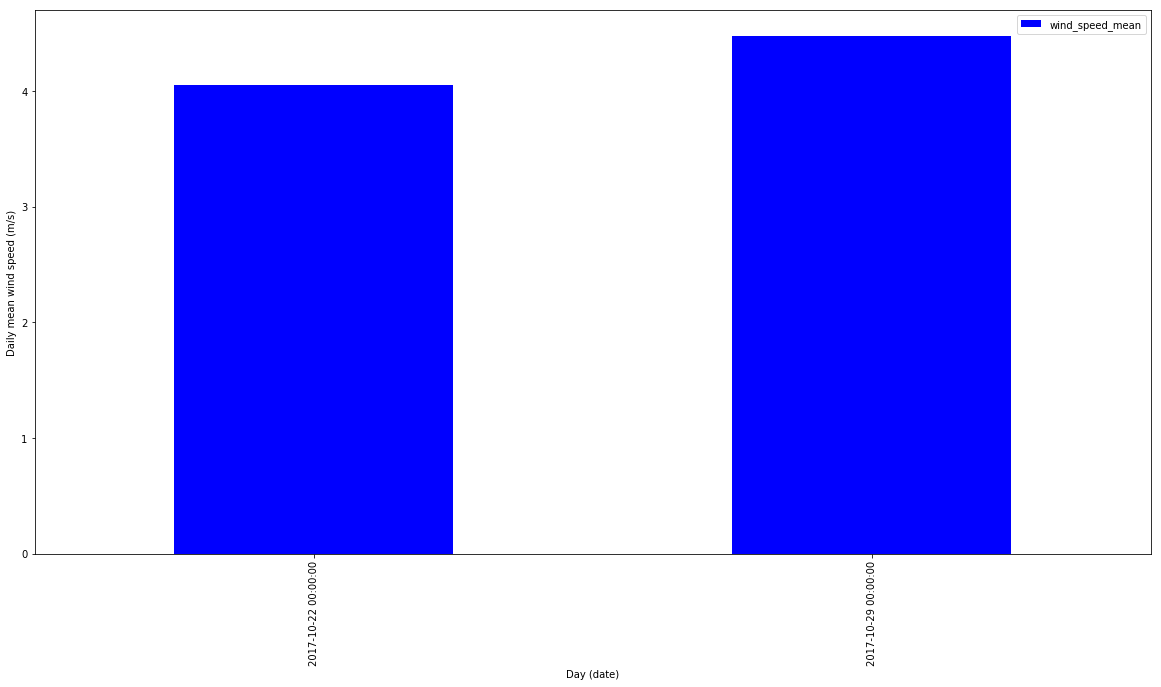

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
days_of_interest.reset_index().plot(x='timestamp', y='wind_speed_mean', ax=ax, kind='bar', color='blue')
plt.ylabel('Daily mean wind speed (m/s)') # is it ?
plt.xlabel('Day (date)')
plt.show()

## PART III: Model fitting for outlier detection (15 points)


### Question III.a.(5/15)

A domain expert indicates that there is problem with the `ZSBN` sensor, which appears after October 24. You decide to fit a linear model to the CO2 measurements of the site, by considering as features the temperature and the humidity. Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October. Can you guess the problem from your plot?

In [31]:
Ia = pd.read_csv('Ia.csv', index_col='timestamp')
zsbn_sensor_data = Ia[Ia['LocationName'] == 'ZSBN']
zsbn_sensor_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZSBN,1031,418.493079,11.146667,92.608017
2017-10-01 00:30:00,ZSBN,1031,418.169200,10.915000,92.220825
2017-10-01 01:00:00,ZSBN,1031,421.749522,10.860000,92.662059
2017-10-01 01:30:00,ZSBN,1031,424.363039,10.820000,92.934809
2017-10-01 02:00:00,ZSBN,1031,423.172512,10.760000,93.407832


In [32]:
X = zsbn_sensor_data[['temperature', 'humidity']].as_matrix()
y = zsbn_sensor_data[['CO2']].as_matrix()

reg = linear_model.LinearRegression()
reg.fit(X,y)
y_pred = reg.predict(X)

In [33]:
simple_model = zsbn_sensor_data[['CO2']]
simple_model.index = pd.to_datetime(simple_model.index)
simple_model = simple_model.copy()
simple_model['y_pred'] = y_pred
simple_model.head()

,CO2,y_pred
timestamp,,
2017-10-01 00:00:00,418.493079,457.861568
2017-10-01 00:30:00,418.169200,454.562046
2017-10-01 01:00:00,421.749522,455.790022
2017-10-01 01:30:00,424.363039,456.501466
2017-10-01 02:00:00,423.172512,457.809678


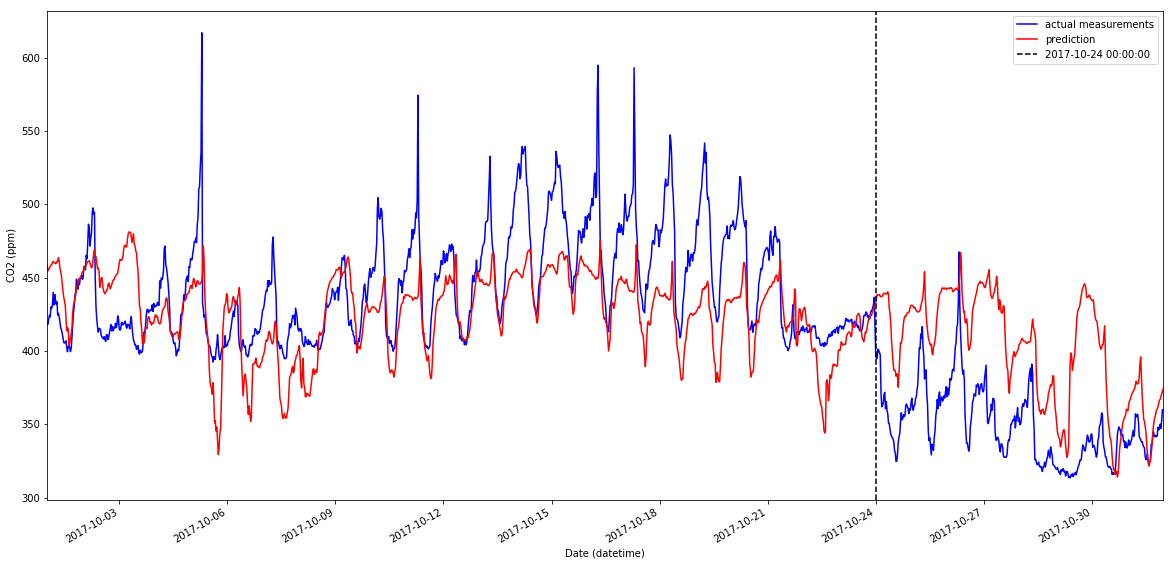

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
simple_model.plot(x=simple_model.index, y ='CO2', label = 'actual measurements', color='blue', ax=ax)
simple_model.plot(x=simple_model.index, y ='y_pred', label = 'prediction', color='red', ax=ax)
plt.axvline(x='2017-10-24 00:00:00', color='k', linestyle='--', label='2017-10-24 00:00:00')
plt.legend()
plt.ylabel('CO2 (ppm)')
plt.xlabel('Date (datetime)')
plt.show()

>Conclusion: There is no obvious difference after the 24th of October that allows us to tell with enough confidence that there might be a problem after this particular date. The prediction has a similar behaviour before and after the dashed line (i.e. it does not match perfectly the blue line).

### Question III.b. (8/15)

In your next attempt to find the problem, you decide to use the temporal and altitude clusters computed in PART II, together with the zone clusters of the city that are already provided, to improve your model. 

First, find the sensors belonging to the same zone and altitude cluster. Keep only the part of the dataframe from Part I.a that matches the same zone and altitude cluster with `ZSBN`.

Then, partition the obtained dataframe into six parts, each corresponding to one of the wind clusters.  

Use the partitioned dataframes to learn a new regression model for each of them. For each linear model, use as features 1) the temperature, 2) the humidity, and 3) the time of the day measured in the range between 0 and 47 (intervals of 30 min). At the end of this step, you should have obtained a simple linear regression model for each wind cluster.

Finally, plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able to clearly detect the drift observed after October 26th.

In [35]:
# sensors from same altitude cluster
zsbn_cluster = SM.loc['ZSBN']['cluster']
sensor_cluster = SM[SM['cluster'] == zsbn_cluster].index

In [36]:
# sensors from same zone
zsbn_zone = sensors_metadata[sensors_metadata['LocationName']=='ZSBN']['zone']
sensor_zone = sensors_metadata[sensors_metadata['zone'] == zsbn_zone.values[0]]['LocationName']

In [37]:
sensor_zone_and_altitude = set(sensor_cluster).union(set(sensor_zone.values))

In [38]:
complete_data = pd.read_csv('Ia.csv', index_col='timestamp')
sensor_cluster_data = complete_data[complete_data['LocationName'].isin(sensor_zone_and_altitude)]
sensor_cluster_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


In [39]:
wind_cluster = pca_components[['cluster']]
wind_cluster.index = pd.to_datetime(wind_cluster.index)
wind_cluster.columns = ['wind_cluster']
wind_cluster.tail()

,wind_cluster
timestamp,
2017-10-27,5
2017-10-28,2
2017-10-29,1
2017-10-30,5
2017-10-31,0


In [40]:
# add upper bound to correctly upsample the last day
wind_cluster = wind_cluster.append(pd.Series(wind_cluster.values[-1], index=wind_cluster.columns, name=(wind_cluster.index[-1] + datetime.timedelta(days=1))))
wind_cluster= wind_cluster.resample('30Min', loffset='1D').pad()
# delete upper bound
wind_cluster = wind_cluster[:-1]
wind_cluster.tail()

,wind_cluster
timestamp,
2017-10-31 21:30:00,0
2017-10-31 22:00:00,0
2017-10-31 22:30:00,0
2017-10-31 23:00:00,0
2017-10-31 23:30:00,0


In [41]:
sensor_cluster_data.index = pd.to_datetime(sensor_cluster_data.index)
sensor_cluster_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


In [42]:
complete_data = sensor_cluster_data.join(wind_cluster)
complete_data.tail()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,wind_cluster
timestamp,,,,,,
2017-10-31 23:30:00,SZGL,1274,559.780106,0.536667,94.749969,0
2017-10-31 23:30:00,RCTZ,1292,552.212598,-0.440000,96.288564,0
2017-10-31 23:30:00,WRTW,1297,502.498423,-0.033333,94.645065,0
2017-10-31 23:30:00,ZSEF,1298,488.848420,2.888333,82.544846,0
2017-10-31 23:30:00,ZLDW,1299,471.881151,3.286667,81.910970,0


In [43]:
keys = pd.date_range('00:00:00', '23:30:00', freq='30Min').time
values = list(range(48))
dictionary = dict(zip(keys, values))

In [44]:
complete_data['time'] = [dictionary[x] for x in complete_data.index.time]
complete_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,wind_cluster,time
timestamp,,,,,,,
2017-10-01,ZGHD,1014,595.004391,11.396667,92.440806,4,0
2017-10-01,ZORL,1015,472.855962,10.513333,92.204295,4,0
2017-10-01,ZTBN,1016,440.373573,11.040000,92.959605,4,0
2017-10-01,ZHRG,1017,425.095878,11.040000,89.914205,4,0
2017-10-01,ZSCH,1018,425.687625,11.370000,91.059886,4,0


In [45]:
models = []

for i in range(complete_data['wind_cluster'].nunique()):
    wind_cluster_data = complete_data[complete_data['wind_cluster'] == i]
    
    X = wind_cluster_data[['temperature', 'humidity', 'time']].as_matrix()
    y = wind_cluster_data[['CO2']].as_matrix()

    reg = linear_model.LinearRegression()
    reg.fit(X,y)
    
    models.append(reg)

In [46]:
updated_zsbn_sensor_data = complete_data[complete_data['LocationName'] == 'ZSBN']
updated_zsbn_sensor_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,wind_cluster,time
timestamp,,,,,,,
2017-10-01 00:00:00,ZSBN,1031,418.493079,11.146667,92.608017,4,0
2017-10-01 00:30:00,ZSBN,1031,418.169200,10.915000,92.220825,4,1
2017-10-01 01:00:00,ZSBN,1031,421.749522,10.860000,92.662059,4,2
2017-10-01 01:30:00,ZSBN,1031,424.363039,10.820000,92.934809,4,3
2017-10-01 02:00:00,ZSBN,1031,423.172512,10.760000,93.407832,4,4


In [47]:
for i in range(updated_zsbn_sensor_data['wind_cluster'].nunique()):
    
    mask = updated_zsbn_sensor_data['wind_cluster'] == i
    wind_cluster_data = updated_zsbn_sensor_data[mask]
    reg = models[i]
    
    X = wind_cluster_data[['temperature', 'humidity', 'time']].as_matrix()
    y_pred = reg.predict(X)
    updated_zsbn_sensor_data = updated_zsbn_sensor_data.copy()
    updated_zsbn_sensor_data.loc[mask, 'y_pred'] = y_pred
        

In [48]:
updated_zsbn_sensor_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,wind_cluster,time,y_pred
timestamp,,,,,,,,
2017-10-01 00:00:00,ZSBN,1031,418.493079,11.146667,92.608017,4,0,523.396173
2017-10-01 00:30:00,ZSBN,1031,418.169200,10.915000,92.220825,4,1,523.686192
2017-10-01 01:00:00,ZSBN,1031,421.749522,10.860000,92.662059,4,2,524.718237
2017-10-01 01:30:00,ZSBN,1031,424.363039,10.820000,92.934809,4,3,525.434796
2017-10-01 02:00:00,ZSBN,1031,423.172512,10.760000,93.407832,4,4,526.533380


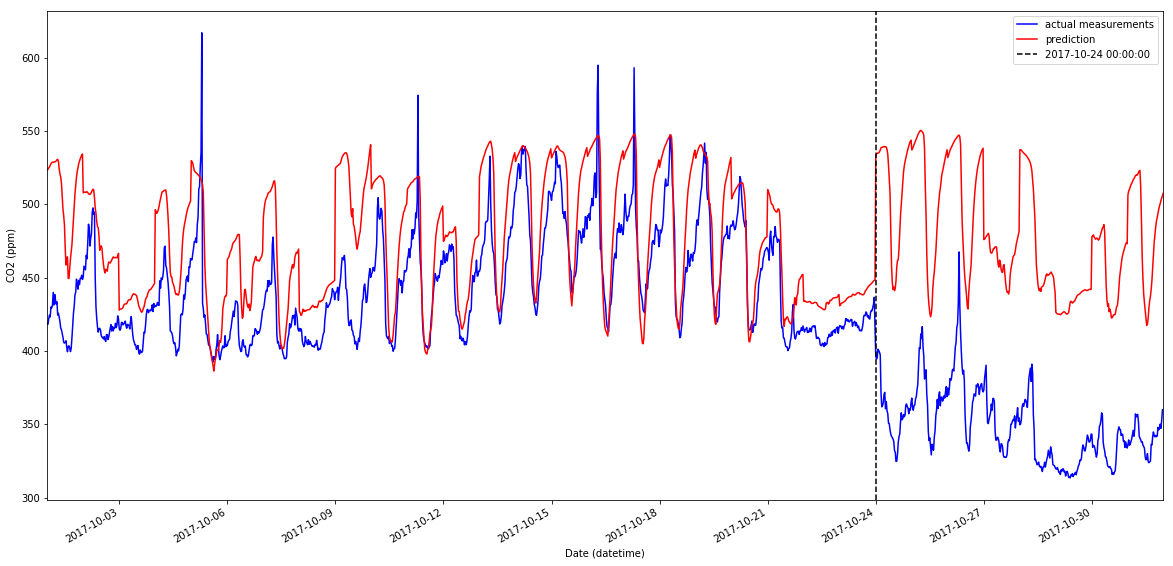

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
updated_zsbn_sensor_data.plot(x=updated_zsbn_sensor_data.index, y ='CO2', label = 'actual measurements', color='blue', ax=ax)
updated_zsbn_sensor_data.plot(x=updated_zsbn_sensor_data.index, y ='y_pred', label = 'prediction', color='red', ax=ax)
plt.axvline(x='2017-10-24 00:00:00', color='k', linestyle='--', label='2017-10-24 00:00:00')
plt.legend()
plt.ylabel('CO2 (ppm)')
plt.xlabel('Date (datetime)')
plt.show()

### Question III.c. (2/15)

Focus on the `KBRL` site. Apply the same procedure by fitting a linear model to the days with similar wind behavior. Plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able detect the outlier observed in the beginning of October. 

In [50]:
# sensors from same altitude cluster
kbrl_cluster = SM.loc['KBRL']['cluster']
sensor_cluster = SM[SM['cluster'] == kbrl_cluster].index
# sensors from same zone
kbrl_zone = sensors_metadata[sensors_metadata['LocationName']=='KBRL']['zone']
sensor_zone = sensors_metadata[sensors_metadata['zone'] == kbrl_zone.values[0]]['LocationName']
# aggregate the two
sensor_zone_and_altitude = set(sensor_cluster).union(set(sensor_zone.values))
# load correct data
complete_data = pd.read_csv('Ia.csv', index_col='timestamp')
sensor_cluster_data = complete_data[complete_data['LocationName'].isin(sensor_zone_and_altitude)]
sensor_cluster_data.head()
# correct index type
sensor_cluster_data.index = pd.to_datetime(sensor_cluster_data.index)
sensor_cluster_data.head()
# merge wind cluster information
complete_data = sensor_cluster_data.join(wind_cluster)
complete_data.tail()
# add time feature
complete_data['time'] = [dictionary[x] for x in complete_data.index.time]
complete_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,wind_cluster,time
timestamp,,,,,,,
2017-10-01,ZRDH,1034,337.298130,10.290000,93.370321,4,0
2017-10-01,ZSZW,1051,491.613250,9.436667,97.978475,4,0
2017-10-01,WMOO,1113,413.867376,10.130000,94.641251,4,0
2017-10-01,ZUBG,1116,408.164987,10.465000,91.909927,4,0
2017-10-01,BSCR,1120,431.558599,10.400000,96.497101,4,0


In [51]:
# train models
models = []

for i in range(complete_data['wind_cluster'].nunique()):
    wind_cluster_data = complete_data[complete_data['wind_cluster'] == i]
    
    X = wind_cluster_data[['temperature', 'humidity', 'time']].as_matrix()
    y = wind_cluster_data[['CO2']].as_matrix()

    reg = linear_model.LinearRegression()
    reg.fit(X,y)
    
    models.append(reg)

In [52]:
# focus on KBRL site
updated_kbrl_sensor_data = complete_data[complete_data['LocationName'] == 'KBRL']
updated_kbrl_sensor_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,wind_cluster,time
timestamp,,,,,,,
2017-10-01 00:00:00,KBRL,1176,402.759373,10.536667,92.604838,4,0
2017-10-01 00:30:00,KBRL,1176,399.279863,10.370000,92.905563,4,1
2017-10-01 01:00:00,KBRL,1176,403.017115,10.326667,92.473231,4,2
2017-10-01 01:30:00,KBRL,1176,404.367073,10.250000,92.098755,4,3
2017-10-01 02:00:00,KBRL,1176,407.390903,10.170000,92.398209,4,4


In [53]:
# make the predictions
for i in range(updated_kbrl_sensor_data['wind_cluster'].nunique()):
    
    mask = updated_kbrl_sensor_data['wind_cluster'] == i
    wind_cluster_data = updated_kbrl_sensor_data[mask]
    reg = models[i]
    
    X = wind_cluster_data[['temperature', 'humidity', 'time']].as_matrix()
    y_pred = reg.predict(X)
    updated_kbrl_sensor_data = updated_kbrl_sensor_data.copy()
    updated_kbrl_sensor_data.loc[mask, 'y_pred'] = y_pred
        

In [54]:
# check
updated_kbrl_sensor_data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,wind_cluster,time,y_pred
timestamp,,,,,,,,
2017-10-01 00:00:00,KBRL,1176,402.759373,10.536667,92.604838,4,0,488.057027
2017-10-01 00:30:00,KBRL,1176,399.279863,10.370000,92.905563,4,1,489.291914
2017-10-01 01:00:00,KBRL,1176,403.017115,10.326667,92.473231,4,2,489.330921
2017-10-01 01:30:00,KBRL,1176,404.367073,10.250000,92.098755,4,3,489.622374
2017-10-01 02:00:00,KBRL,1176,407.390903,10.170000,92.398209,4,4,490.276148


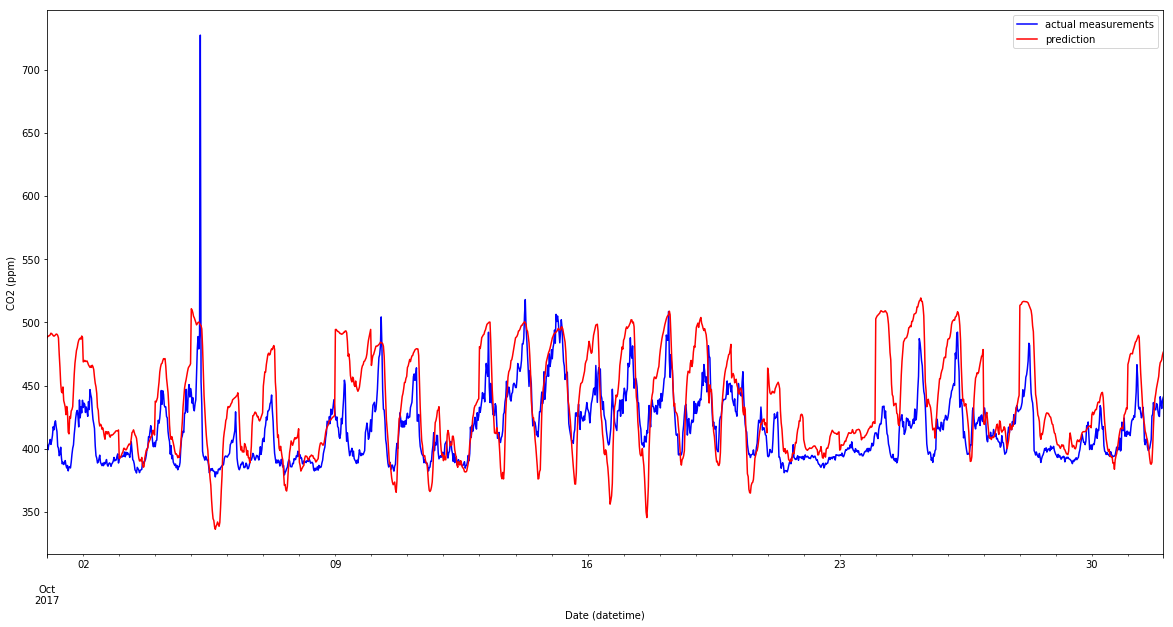

In [55]:
# plot the results
fig, ax = plt.subplots(figsize=(20,10))
updated_kbrl_sensor_data.plot(x=updated_kbrl_sensor_data.index, y ='CO2', label = 'actual measurements', color='blue', ax=ax)
updated_kbrl_sensor_data.plot(x=updated_kbrl_sensor_data.index, y ='y_pred', label = 'prediction', color='red', ax=ax)
plt.legend()
plt.ylabel('CO2 (ppm)')
plt.xlabel('Date (datetime)')
plt.show()

## PART IV: Share your work with the domain expert (10 points)

The domain experts would like to try out your work but they have python 2.6 installed and they
do not want to install anaconda3.
They tried to create a `Dockerfile` in order to build a Docker image and play with the notebook
but it didn't work.

Use
```bash
docker build -t co2notebook .
```
and
```bash
docker run --init --rm -it -p 8888:8888 co2notebook
```
to play with the Docker image.
More details can be found in the README file.

Notice how the notebook opens but that the first code cell cannot be executed.
```
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
[...]
```

### Question IV.a. (10/10)

Edit the `Dockerfile` so that you can execute the whole notebook from the `docker run` command.
This means that all the cells should run, not just the first one.

While this task can be completed by minor modifications, you are free to edit any part of the `Dockerfile`.

For a complete read over how a `Dockerfile` works, head to https://docs.docker.com/engine/reference/builder/.